# 実践その参（物体認識パート）
Yolo_v3を使って物体認識モデルをトレーニングする



## 条件
- https://public.roboflow.com/ のパブリックデータセットから気になるデータセット（アライグマ以外）をダウンロード、あるいは https://www.makesense.ai/ のようなアノテーションツールで独自のデータセットを作成、それを使って学習を行うこと。
- 学習のループは自分で書くこと


コードは基本的に下記レポジトリから拝借しています。  
https://github.com/DeNA/PyTorch_YOLOv3



データは以下のウェブサイトから拝借しています。  
https://public.roboflow.com/

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ここにStudent IDを記載しておいてください。
Student_ID = "Akira Endo"

## 1. データの準備

自分のデータセットを準備する。  

方法は問わないが、150件以上用意すること。

https://public.roboflow.com/ のアライグマのデータセットはサンプルとして使われているのでNG。  
全体としてスクリプトがどう動作するのか確認するのに使ってください。


In [1]:
# 以下はアライグマのサンプル

# アライグマのデータセットをダウンロードする
# ! wget https://shabelab.com/mp3/racoon.tar.gz

# Chess Piecesのデータセットをダウンロードする
# !curl -L "https://public.roboflow.com/ds/v7IgnCDPS2?key=CqP7Tnys0T" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# Ankeyのデータセットをダウンロードする
!curl -L "https://public.roboflow.com/ds/nU0PrRHNzL?key=ETYukrqWsU" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1135      0 --:--:-- --:--:-- --:--:--  1134
100 6838k  100 6838k    0     0  1689k      0  0:00:04  0:00:04 --:--:-- 2322k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: test/_annotations.txt   
 extracting: test/_classes.txt       
 extracting: test/picture134_jpeg.rf.6df354d34a186d4292c9a48b3f5a7684.jpg  
 extracting: test/picture137_jpeg.rf.007d83fe701f116b547011b5b472f213.jpg  
 extracting: test/picture140_jpeg.rf.092cf3ba9fa16082e570a616e45a3091.jpg  
 extracting: test/picture141_jpeg.rf.cc0527f0d6192e29d2fc894a118314c0.jpg  
 extracting: test/picture14_jpeg.rf.71627a2c49f8fb89f834a4e616a3220b.jpg  
 extracting: test/picture16_jpeg.rf.0da08a35bc10df3383a89fdde96f8019.jpg  
 extracting: test/picture177_jpeg.rf.f2b18682b15e420e6a

In [ ]:
# 以下はアライグマのサンプル

# ダウンロードしたデータを解凍する
# ! tar xvzf racoon.tar.gz

# データセットの準備

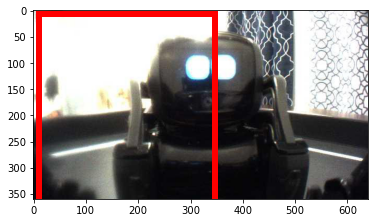

In [60]:
# 以下はアライグマのサンプル
# 自分のデータでみてみましょう

# サンプルを一つみてみましょう

from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.patches as patches
from PIL import Image

im = Image.open("test/images/picture14_jpeg.rf.71627a2c49f8fb89f834a4e616a3220b.jpg")

# Create figure and axes
fig, ax = plt.subplots()

ax.imshow(im)

rect = patches.Rectangle((10, 7), 336, 464, linewidth=6, edgecolor='r', facecolor='none')

# Display the image
ax.add_patch(rect)

# データセットの準備

以下にアライグマのサンプル（意図的に他のYoloのデータセットとか少し構造を変えています）で動くDataset関連のスクリプトを記載します。  
自分のデータで動くよう適宜書き換えてください。  
Yoloはプログラム部分がヘビーですが、わからないところはそのままコピーして使って頂いて結構です。

In [61]:
import torch

In [62]:
def label2yolobox(labels, info_img, maxsize, lrflip):
    """
    Transform coco labels to yolo box labels
    Args:
        labels (numpy.ndarray): label data whose shape is :math:`(N, 5)`.
            Each label consists of [class, x, y, w, h] where \
                class (float): class index.
                x, y, w, h (float) : coordinates of \
                    left-top points, width, and height of a bounding box.
                    Values range from 0 to width or height of the image.
        info_img : tuple of h, w, nh, nw, dx, dy.
            h, w (int): original shape of the image
            nh, nw (int): shape of the resized image without padding
            dx, dy (int): pad size
        maxsize (int): target image size after pre-processing
        lrflip (bool): horizontal flip flag

    Returns:
        labels:label data whose size is :math:`(N, 5)`.
            Each label consists of [class, xc, yc, w, h] where
                class (float): class index.
                xc, yc (float) : center of bbox whose values range from 0 to 1.
                w, h (float) : size of bbox whose values range from 0 to 1.
    """
    h, w, nh, nw, dx, dy = info_img
    x1 = labels[:, 1] / w
    y1 = labels[:, 2] / h
    x2 = (labels[:, 1] + labels[:, 3]) / w
    y2 = (labels[:, 2] + labels[:, 4]) / h
    labels[:, 1] = (((x1 + x2) / 2) * nw + dx) / maxsize
    labels[:, 2] = (((y1 + y2) / 2) * nh + dy) / maxsize
    labels[:, 3] *= nw / w / maxsize
    labels[:, 4] *= nh / h / maxsize
    if lrflip:
        labels[:, 1] = 1 - labels[:, 1]
    return labels


In [63]:
def preprocess(img, imgsize, jitter, random_placing=False):
    """
    Image preprocess for yolo input
    Pad the shorter side of the image and resize to (imgsize, imgsize)
    Args:
        img (numpy.ndarray): input image whose shape is :math:`(H, W, C)`.
            Values range from 0 to 255.
        imgsize (int): target image size after pre-processing
        jitter (float): amplitude of jitter for resizing
        random_placing (bool): if True, place the image at random position

    Returns:
        img (numpy.ndarray): input image whose shape is :math:`(C, imgsize, imgsize)`.
            Values range from 0 to 1.
        info_img : tuple of h, w, nh, nw, dx, dy.
            h, w (int): original shape of the image
            nh, nw (int): shape of the resized image without padding
            dx, dy (int): pad size
    """


    h, w, _ = img.shape
    img = img[:, :, ::-1]
    assert img is not None

    if jitter > 0:
        # add jitter
        dw = jitter * w
        dh = jitter * h
        rand_w = np.random.uniform(low=-dw, high=dw)
        rand_h = np.random.uniform(low=-dh, high=dh)
        new_ar = (w + rand_w) / (h + rand_h)
    else:
        new_ar = w / h

    if new_ar < 1:
        nh = imgsize
        nw = nh * new_ar
    else:
        nw = imgsize
        nh = nw / new_ar
    nw, nh = int(nw), int(nh)

    if random_placing:
        dx = int(np.random.uniform(imgsize - nw))
        dy = int(np.random.uniform(imgsize - nh))
    else:
        dx = (imgsize - nw) // 2
        dy = (imgsize - nh) // 2

    img = cv2.resize(img, (nw, nh))
    sized = np.ones((imgsize, imgsize, 3), dtype=np.uint8) * 127
    sized[dy:dy+nh, dx:dx+nw, :] = img

    # print("nh: ", nh, ", nw: ", nw)

    info_img = (h, w, nh, nw, dx, dy)
    return sized, info_img


In [64]:
from torch.utils.data import Dataset
import json
import cv2
import codecs
import numpy as np

# dataset

class MyDataset(Dataset):
    """
    dataset class.
    img_size=416
    """
    def __init__(self,
                 csv_path=None,
                 class_names=None,
                 img_size=608,
                 augmentation=None, 
                 min_size=1):
        """
        Args:
        """

        if csv_path is None:
            raise Exception("csv path is not specified.")

        if class_names is None:
            raise Exception("please specify class names.")

        self.max_labels = 30

        self.img_size = img_size
        self.min_size = min_size

        self.lrflip = augmentation['LRFLIP']
        self.jitter = augmentation['JITTER']
        self.random_placing = augmentation['RANDOM_PLACING']
        self.hue = augmentation['HUE']
        self.saturation = augmentation['SATURATION']
        self.exposure = augmentation['EXPOSURE']
        self.random_distort = augmentation['RANDOM_DISTORT']
        self.random_croppig_target = False
        self.random_croppig_base = False

        _f = open(csv_path, "r")
        _raw = _f.read()
        _raw = _raw.strip()
        _csv_list = _raw.split("\n")

        self.csv_list = _csv_list
        
        self.class_names = class_names
        self.class_dict = {class_name: i for i, class_name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.csv_list)

    def __getitem__(self, index):

        _row = self.csv_list[index]

        img_path = _row.split(",")[0]
        anno_path = _row.split(",")[1]

        lrflip = False

        # load image and preprocess
        img = self._read_image(img_path)

        # load labels
        boxes, labels = self._get_annotation(anno_path)

        img, info_img = preprocess(img, 
                                   self.img_size, 
                                   jitter=self.jitter,
                                   random_placing=self.random_placing)

        img = np.transpose(img / 255., (2, 0, 1))

        # concat class + box
        label_list = []

        for l, b in zip(labels, boxes):

            # refine box
            x1 = float(b[0])
            y1 = float(b[1])
            x2 = float(b[2])
            y2 = float(b[3])

            # seems _get_annotation convert (x1, y1, w, h) > (x1, y1, x2, y2)
            b = [x1, y1, x2-x1, y2-y1]

            if b[2] > self.min_size and b[3] > self.min_size:
                label_list.append([])
                label_list[-1].append(l)
                label_list[-1].extend(b)

        labels = label_list

        padded_labels = np.zeros((self.max_labels, 5))
        if len(labels) > 0:
            labels = np.stack(labels)
            labels = label2yolobox(labels, info_img, self.img_size, lrflip)
            padded_labels[range(len(labels))[:self.max_labels]] = labels[:self.max_labels]

        padded_labels = torch.from_numpy(padded_labels)

        return img, padded_labels, info_img

    def _get_annotation(self, annotation_file_path):

        objects = json.load(codecs.open(annotation_file_path, 'r', 'utf-8-sig'))
        objects = objects["annotations"]

        boxes = []
        labels = []

        for object in objects:

            class_name = "test"

            # we're only concerned with clases in our list
            if class_name in self.class_dict:

                bbox = object["bbox"]
                if bbox is not None:

                    x1 = bbox.split(" ")[0]
                    y1 = bbox.split(" ")[1]
                    w = bbox.split(" ")[2]
                    h = bbox.split(" ")[3]

                    # VOC dataset format follows Matlab, in which indexes start from 0
                    # We do not need this here...
                    x1 = float(x1) - 1
                    y1 = float(y1) - 1
                    x2 = x1 + float(w)
                    y2 = y1 + float(h)
                    boxes.append([x1, y1, x2, y2])

                    labels.append(self.class_dict[class_name])

#             # we're only concerned with clases in our list
#             # for banbox which was typo...
#             if class_name in self.class_dict:

#                 bbox = object["bbox"]
#                 if bbox is not None:

#                     x1 = bbox.split(" ")[0]
#                     y1 = bbox.split(" ")[1]
#                     w = bbox.split(" ")[2]
#                     h = bbox.split(" ")[3]

#                     # VOC dataset format follows Matlab, in which indexes start from 0
#                     x1 = float(x1) - 1
#                     y1 = float(y1) - 1
#                     x2 = x1 + float(w)
#                     y2 = y1 + float(h)

#                     boxes.append([x1, y1, x2, y2])

#                     labels.append(self.class_dict[class_name])

        return (np.array(boxes, dtype=np.float32),
                np.array(labels, dtype=np.int64))

    def _read_image(self, image_path):
        # print("image_path: ", image_path)
        image = cv2.imread(str(image_path))
        # print("image: ", image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image



In [65]:
# ここでDatasetをインスタンス化します。
# ここら辺も適宜自分のデータセットに合わせて書き換えてください。

# csv_path = "./racoon/train_val.csv"
csv_path = "./test/train_val.csv" 

# 自分のデータセットに合わせて書き換えてください。
class_names = [
    "test",
]

cfg_augmentation = {
    "RANDRESIZE": False,
    "JITTER": False,
    "RANDOM_PLACING": False,
    "HUE": False,
    "SATURATION": 1.5,
    "EXPOSURE": 1.5,
    "LRFLIP": False,
    "RANDOM_DISTORT": False,
}

dataset = MyDataset(csv_path=csv_path, class_names=class_names, augmentation=cfg_augmentation)

In [66]:
len(dataset)

3

In [67]:
# dataloader

from torch.utils.data import DataLoader

batch_size = 4

dataloader  = DataLoader(dataset, batch_size, num_workers=4, shuffle=True)

In [68]:
# データが少なくて評価用と分ける余裕がないので、同じもので擬似的に定義しておきます。

val_dataset = MyDataset(csv_path=csv_path, class_names=class_names, augmentation=cfg_augmentation)
val_dataloader  = DataLoader(dataset, batch_size, num_workers=4, shuffle=False)

In [69]:
# define train block
def train(args, model, device, train_loader, optimizer, epoch):
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if args.dry_run:
                break
                
                

In [70]:
# define test block
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )



In [71]:
# training loop 
for epoch in range(1, args.epochs + 1):
    
    # training loop
    train(args, model, device, my_train_loader, optimizer, epoch)
    
    # validation loop
    test(model, device, test_loader)
    scheduler.step()


NameError: name 'args' is not defined

# アーキテクチャ

Yoloはアーキテクチャの中にPythonのコードがたくさんあってこれをきちんと理解するのは大変です。  
何をやっているのかわからない方はコンセプトだけ理解してそのまま使ってください。

In [72]:
def bboxes_iou(bboxes_a, bboxes_b, xyxy=True):
    """Calculate the Intersection of Unions (IoUs) between bounding boxes.
    IoU is calculated as a ratio of area of the intersection
    and area of the union.

    Args:
        bbox_a (array): An array whose shape is :math:`(N, 4)`.
            :math:`N` is the number of bounding boxes.
            The dtype should be :obj:`numpy.float32`.
        bbox_b (array): An array similar to :obj:`bbox_a`,
            whose shape is :math:`(K, 4)`.
            The dtype should be :obj:`numpy.float32`.
    Returns:
        array:
        An array whose shape is :math:`(N, K)`. \
        An element at index :math:`(n, k)` contains IoUs between \
        :math:`n` th bounding box in :obj:`bbox_a` and :math:`k` th bounding \
        box in :obj:`bbox_b`.

    from: https://github.com/chainer/chainercv
    """
    if bboxes_a.shape[1] != 4 or bboxes_b.shape[1] != 4:
        raise IndexError

    # top left
    if xyxy:
        tl = torch.max(bboxes_a[:, None, :2], bboxes_b[:, :2])
        # bottom right
        br = torch.min(bboxes_a[:, None, 2:], bboxes_b[:, 2:])
        area_a = torch.prod(bboxes_a[:, 2:] - bboxes_a[:, :2], 1)
        area_b = torch.prod(bboxes_b[:, 2:] - bboxes_b[:, :2], 1)
    else:
        tl = torch.max((bboxes_a[:, None, :2] - bboxes_a[:, None, 2:] / 2),
                        (bboxes_b[:, :2] - bboxes_b[:, 2:] / 2))
        # bottom right
        br = torch.min((bboxes_a[:, None, :2] + bboxes_a[:, None, 2:] / 2),
                        (bboxes_b[:, :2] + bboxes_b[:, 2:] / 2))

        area_a = torch.prod(bboxes_a[:, 2:], 1)
        area_b = torch.prod(bboxes_b[:, 2:], 1)
    en = (tl < br).type(tl.type()).prod(dim=2)
    area_i = torch.prod(br - tl, 2) * en  # * ((tl < br).all())
    return area_i / (area_a[:, None] + area_b - area_i)

In [73]:
import torch
import torch.nn as nn
import numpy as np
# from utils.utils import bboxes_iou

# yolo layer
class YOLOLayer(nn.Module):
    """
    detection layer corresponding to yolo_layer.c of darknet
    """
    def __init__(self, config_model, layer_no, in_ch, ignore_thre=0.7):
        """
        Args:
            config_model (dict) : model configuration.
                ANCHORS (list of tuples) :
                ANCH_MASK:  (list of int list): index indicating the anchors to be
                    used in YOLO layers. One of the mask group is picked from the list.
                N_CLASSES (int): number of classes
            layer_no (int): YOLO layer number - one from (0, 1, 2).
            in_ch (int): number of input channels.
            ignore_thre (float): threshold of IoU above which objectness training is ignored.
        """

        super(YOLOLayer, self).__init__()
        strides = [32, 16, 8] # fixed
        self.anchors = config_model['ANCHORS']
        self.anch_mask = config_model['ANCH_MASK'][layer_no]
        self.n_anchors = len(self.anch_mask)
        self.n_classes = config_model['N_CLASSES']
        self.ignore_thre = ignore_thre
        self.l2_loss = nn.MSELoss(size_average=False)
        # self.bce_loss = nn.BCEWithLogitsLoss(size_average=False)
        self.bce_loss = nn.BCELoss(size_average=False)
        self.stride = strides[layer_no]
        self.all_anchors_grid = [(w / self.stride, h / self.stride)
                                 for w, h in self.anchors]
        self.masked_anchors = [self.all_anchors_grid[i]
                               for i in self.anch_mask]
        self.ref_anchors = np.zeros((len(self.all_anchors_grid), 4))
        self.ref_anchors[:, 2:] = np.array(self.all_anchors_grid)
        self.ref_anchors = torch.FloatTensor(self.ref_anchors)
        self.conv = nn.Conv2d(in_channels=in_ch,
                              out_channels=self.n_anchors * (self.n_classes + 5),
                              kernel_size=1, stride=1, padding=0)

    def forward(self, xin, labels=None):
        """
        In this
        Args:
            xin (torch.Tensor): input feature map whose size is :math:`(N, C, H, W)`, \
                where N, C, H, W denote batchsize, channel width, height, width respectively.
            labels (torch.Tensor): label data whose size is :math:`(N, K, 5)`. \
                N and K denote batchsize and number of labels.
                Each label consists of [class, xc, yc, w, h]:
                    class (float): class index.
                    xc, yc (float) : center of bbox whose values range from 0 to 1.
                    w, h (float) : size of bbox whose values range from 0 to 1.
        Returns:
            loss (torch.Tensor): total loss - the target of backprop.
            loss_xy (torch.Tensor): x, y loss - calculated by binary cross entropy (BCE) \
                with boxsize-dependent weights.
            loss_wh (torch.Tensor): w, h loss - calculated by l2 without size averaging and \
                with boxsize-dependent weights.
            loss_obj (torch.Tensor): objectness loss - calculated by BCE.
            loss_cls (torch.Tensor): classification loss - calculated by BCE for each class.
            loss_l2 (torch.Tensor): total l2 loss - only for logging.
        """

        output = self.conv(xin)

        batchsize = output.shape[0]
        fsize = output.shape[2]
        n_ch = 5 + self.n_classes
        dtype = torch.cuda.FloatTensor if xin.is_cuda else torch.FloatTensor

        output = output.view(batchsize, self.n_anchors, n_ch, fsize, fsize)
        output = output.permute(0, 1, 3, 4, 2)  # .contiguous()

        # logistic activation for xy, obj, cls
        output[..., np.r_[:2, 4:n_ch]] = torch.sigmoid(output[..., np.r_[:2, 4:n_ch]])

        # calculate pred - xywh obj cls
        x_shift = dtype(np.broadcast_to(np.arange(fsize, dtype=np.float32), output.shape[:4]))
        y_shift = dtype(np.broadcast_to(np.arange(fsize, dtype=np.float32).reshape(fsize, 1), output.shape[:4]))
        masked_anchors = np.array(self.masked_anchors)

        w_anchors = dtype(np.broadcast_to(np.reshape(
            masked_anchors[:, 0], (1, self.n_anchors, 1, 1)), output.shape[:4]))
        h_anchors = dtype(np.broadcast_to(np.reshape(
            masked_anchors[:, 1], (1, self.n_anchors, 1, 1)), output.shape[:4]))

        pred = output.clone()
        pred[..., 0] = pred[..., 0] + x_shift
        pred[..., 1] = pred[..., 1] + y_shift
        pred[..., 2] = torch.exp(pred[..., 2]) * w_anchors
        pred[..., 3] = torch.exp(pred[..., 3]) * h_anchors

        if labels is None:  # not training
            pred[..., :4] = pred[..., :4] * self.stride
            return pred.reshape(batchsize, -1, n_ch).data

        pred = pred[..., :4].data

        # target assignment

        tgt_mask = torch.zeros(batchsize, self.n_anchors,
                               fsize, fsize, 4 + self.n_classes).type(dtype)
        obj_mask = torch.ones(batchsize, self.n_anchors,
                              fsize, fsize).type(dtype)
        tgt_scale = torch.zeros(batchsize, self.n_anchors,
                                fsize, fsize, 2).type(dtype)

        target = torch.zeros(batchsize, self.n_anchors,
                             fsize, fsize, n_ch).type(dtype)

        labels = labels.cpu().data
        nlabel = (labels.sum(dim=2) > 0).sum(dim=1)  # number of objects

        truth_x_all = labels[:, :, 1] * fsize
        truth_y_all = labels[:, :, 2] * fsize
        truth_w_all = labels[:, :, 3] * fsize
        truth_h_all = labels[:, :, 4] * fsize
        truth_i_all = truth_x_all.to(torch.int16).numpy()
        truth_j_all = truth_y_all.to(torch.int16).numpy()

        for b in range(batchsize):
            n = int(nlabel[b])
            if n == 0:
                continue
            truth_box = dtype(np.zeros((n, 4)))
            truth_box[:n, 2] = truth_w_all[b, :n]
            truth_box[:n, 3] = truth_h_all[b, :n]
            truth_i = truth_i_all[b, :n]
            truth_j = truth_j_all[b, :n]

            # calculate iou between truth and reference anchors
            anchor_ious_all = bboxes_iou(truth_box.cpu(), self.ref_anchors)
            best_n_all = np.argmax(anchor_ious_all, axis=1)
            best_n = best_n_all % 3
            best_n_mask = ((best_n_all == self.anch_mask[0]) | (
                best_n_all == self.anch_mask[1]) | (best_n_all == self.anch_mask[2]))

            truth_box[:n, 0] = truth_x_all[b, :n]
            truth_box[:n, 1] = truth_y_all[b, :n]

            pred_ious = bboxes_iou(
                pred[b].reshape(-1, 4), truth_box, xyxy=False)
            pred_best_iou, _ = pred_ious.max(dim=1)
            pred_best_iou = (pred_best_iou > self.ignore_thre)
            pred_best_iou = pred_best_iou.view(pred[b].shape[:3])
            # set mask to zero (ignore) if pred matches truth
            obj_mask[b] = ~pred_best_iou 
            # obj_mask[b] = 1 - pred_best_iou

            if sum(best_n_mask) == 0:
                continue

            for ti in range(best_n.shape[0]):
                if best_n_mask[ti] == 1:
                    i, j = truth_i[ti], truth_j[ti]
                    a = best_n[ti]
                    obj_mask[b, a, j, i] = 1
                    tgt_mask[b, a, j, i, :] = 1
                    target[b, a, j, i, 0] = truth_x_all[b, ti] - truth_x_all[b, ti].to(torch.int16).to(torch.float)
                    target[b, a, j, i, 1] = truth_y_all[b, ti] - truth_y_all[b, ti].to(torch.int16).to(torch.float)
                    target[b, a, j, i, 2] = torch.log(truth_w_all[b, ti] / torch.Tensor(self.masked_anchors)[best_n[ti], 0] + 1e-16)
                    target[b, a, j, i, 3] = torch.log(truth_h_all[b, ti] / torch.Tensor(self.masked_anchors)[best_n[ti], 1] + 1e-16)
                    target[b, a, j, i, 4] = 1
                    target[b, a, j, i, 5 + labels[b, ti, 0].to(torch.int16).numpy()] = 1
                    tgt_scale[b, a, j, i, :] = torch.sqrt(2 - truth_w_all[b, ti] * truth_h_all[b, ti] / fsize / fsize)

        # loss calculation
        output[..., 4] = output[..., 4] * obj_mask
        output[..., np.r_[0:4, 5:n_ch]] = output[..., np.r_[0:4, 5:n_ch]] * tgt_mask
        output[..., 2:4] = output[..., 2:4] * tgt_scale

        target[..., 4] = target[..., 4] * obj_mask
        target[..., np.r_[0:4, 5:n_ch]] = target[..., np.r_[0:4, 5:n_ch]] * tgt_mask
        target[..., 2:4] = target[..., 2:4] * tgt_scale
        
        bceloss = nn.BCELoss(weight=tgt_scale*tgt_scale,
                             size_average=False)  # weighted BCEloss
        
        # bceloss = nn.BCEWithLogitsLoss(weight=tgt_scale*tgt_scale,
        #                      size_average=False)  # weighted BCEloss

        try:
            loss_xy = bceloss(output[..., :2], target[..., :2])
        except:
            print(">>>>xy")
            print(" - target")
            print(target[..., :2])
            print(" - output")
            print(output[..., :2])
            print(output.shape)
            print(output[..., :2])

        loss_wh = self.l2_loss(output[..., 2:4], target[..., 2:4]) / 2

        try:
            loss_obj = self.bce_loss(output[..., 4], target[..., 4])
        except:
            print(">>>>obj")
        try:
            loss_cls = self.bce_loss(output[..., 5:], target[..., 5:])
        except:
            print(">>>>cls")
        
        loss_l2 = self.l2_loss(output, target)

        loss = loss_xy + loss_wh + loss_obj + loss_cls

        return loss, loss_xy, loss_wh, loss_obj, loss_cls, loss_l2


In [74]:
import torch
import torch.nn as nn

from collections import defaultdict
# from models.yolo_layer import YOLOLayer

def add_conv(in_ch, out_ch, ksize, stride):
    """
    Add a conv2d / batchnorm / leaky ReLU block.
    Args:
        in_ch (int): number of input channels of the convolution layer.
        out_ch (int): number of output channels of the convolution layer.
        ksize (int): kernel size of the convolution layer.
        stride (int): stride of the convolution layer.
    Returns:
        stage (Sequential) : Sequential layers composing a convolution block.
    """
    stage = nn.Sequential()
    pad = (ksize - 1) // 2
    stage.add_module('conv', nn.Conv2d(in_channels=in_ch,
                                       out_channels=out_ch, kernel_size=ksize, stride=stride,
                                       padding=pad, bias=False))
    stage.add_module('batch_norm', nn.BatchNorm2d(out_ch))
    stage.add_module('leaky', nn.LeakyReLU(0.1))
    return stage


class resblock(nn.Module):
    """
    Sequential residual blocks each of which consists of \
    two convolution layers.
    Args:
        ch (int): number of input and output channels.
        nblocks (int): number of residual blocks.
        shortcut (bool): if True, residual tensor addition is enabled.
    """
    def __init__(self, ch, nblocks=1, shortcut=True):

        super().__init__()
        self.shortcut = shortcut
        self.module_list = nn.ModuleList()
        for i in range(nblocks):
            resblock_one = nn.ModuleList()
            resblock_one.append(add_conv(ch, ch//2, 1, 1))
            resblock_one.append(add_conv(ch//2, ch, 3, 1))
            self.module_list.append(resblock_one)

    def forward(self, x):
        for module in self.module_list:
            h = x
            for res in module:
                h = res(h)
            x = x + h if self.shortcut else h
        return x


def create_yolov3_modules(config_model, ignore_thre):
    """
    Build yolov3 layer modules.
    Args:
        config_model (dict): model configuration.
            See YOLOLayer class for details.
        ignore_thre (float): used in YOLOLayer.
    Returns:
        mlist (ModuleList): YOLOv3 module list.
    """

    # DarkNet53
    mlist = nn.ModuleList()
    mlist.append(add_conv(in_ch=3, out_ch=32, ksize=3, stride=1))  # 0 
    mlist.append(add_conv(in_ch=32, out_ch=64, ksize=3, stride=2)) # 1
    mlist.append(resblock(ch=64)) # 2
    mlist.append(add_conv(in_ch=64, out_ch=128, ksize=3, stride=2)) # 3
    mlist.append(resblock(ch=128, nblocks=2)) # 4
    mlist.append(add_conv(in_ch=128, out_ch=256, ksize=3, stride=2)) # 5
    mlist.append(resblock(ch=256, nblocks=8))    # shortcut 1 from here # 6
    mlist.append(add_conv(in_ch=256, out_ch=512, ksize=3, stride=2)) # 7
    mlist.append(resblock(ch=512, nblocks=8))    # shortcut 2 from here # 8
    mlist.append(add_conv(in_ch=512, out_ch=1024, ksize=3, stride=2)) # 9
    mlist.append(resblock(ch=1024, nblocks=4))  # 10

    # YOLOv3
    mlist.append(resblock(ch=1024, nblocks=2, shortcut=False))  #11
    mlist.append(add_conv(in_ch=1024, out_ch=512, ksize=1, stride=1)) # 12
    
    # 1st yolo branch
    mlist.append(add_conv(in_ch=512, out_ch=1024, ksize=3, stride=1)) # 13
    mlist.append(YOLOLayer(config_model, layer_no=0, in_ch=1024, ignore_thre=ignore_thre)) # 14

    mlist.append(add_conv(in_ch=512, out_ch=256, ksize=1, stride=1)) # 15
    mlist.append(nn.Upsample(scale_factor=2, mode='nearest')) # 16
    mlist.append(add_conv(in_ch=768, out_ch=256, ksize=1, stride=1)) # 17
    mlist.append(add_conv(in_ch=256, out_ch=512, ksize=3, stride=1)) # 18
    mlist.append(resblock(ch=512, nblocks=1, shortcut=False)) # 19
    mlist.append(add_conv(in_ch=512, out_ch=256, ksize=1, stride=1)) # 20

    # 2nd yolo branch
    mlist.append(add_conv(in_ch=256, out_ch=512, ksize=3, stride=1)) # 21
    mlist.append(YOLOLayer(config_model, layer_no=1, in_ch=512, ignore_thre=ignore_thre)) # 22

    mlist.append(add_conv(in_ch=256, out_ch=128, ksize=1, stride=1)) # 23
    mlist.append(nn.Upsample(scale_factor=2, mode='nearest')) # 24
    mlist.append(add_conv(in_ch=384, out_ch=128, ksize=1, stride=1)) # 25
    mlist.append(add_conv(in_ch=128, out_ch=256, ksize=3, stride=1)) # 26
    mlist.append(resblock(ch=256, nblocks=2, shortcut=False)) # 27

    # yolo branch
    mlist.append(YOLOLayer(config_model, layer_no=2, in_ch=256, ignore_thre=ignore_thre)) # 28

    return mlist

class YOLOv3(nn.Module):
    """
    YOLOv3 model module. The module list is defined by create_yolov3_modules function. \
    The network returns loss values from three YOLO layers during training \
    and detection results during test.
    """
    def __init__(self, config_model, ignore_thre=0.7):
        """
        Initialization of YOLOv3 class.
        Args:
            config_model (dict): used in YOLOLayer.
            ignore_thre (float): used in YOLOLayer.
        """
        super(YOLOv3, self).__init__()

        if config_model['TYPE'] == 'YOLOv3':
            self.module_list = create_yolov3_modules(config_model, ignore_thre)
        else:
            raise Exception('Model name {} is not available'.format(config_model['TYPE']))

    def forward(self, x, targets=None):
        """
        Forward path of YOLOv3.
        Args:
            x (torch.Tensor) : input data whose shape is :math:`(N, C, H, W)`, \
                where N, C are batchsize and num. of channels.
            targets (torch.Tensor) : label array whose shape is :math:`(N, 50, 5)`

        Returns:
            training:
                output (torch.Tensor): loss tensor for backpropagation.
            test:
                output (torch.Tensor): concatenated detection results.
        """
        train = targets is not None
        output = []
        self.loss_dict = defaultdict(float)
        route_layers = []


        for i, module in enumerate(self.module_list):
            # yolo layers
            if i in [14, 22, 28]:
                if train:
                    x, *loss_dict = module(x, targets)                    
                    for name, loss in zip(['xy', 'wh', 'conf', 'cls', 'l2'] , loss_dict):
                        self.loss_dict[name] += loss
                else:
                    x = module(x)
                output.append(x)
            else:
                x = module(x)
            # route layers
            if i in [6, 8, 12, 20]: # 6,8 = high resolution map, 12,20 = 1 befor yolo map
                route_layers.append(x)
            if i == 14: # 1st yolo layer
                x = route_layers[2] # module_list[12]
            if i == 22:  # yolo 2nd 
                x = route_layers[3] # module_list[20]
            if i == 16: # 1st up sampling
                x = torch.cat((x, route_layers[1]), 1) # module_list[6]
            if i == 24: # 2nd up sampling
                x = torch.cat((x, route_layers[0]), 1) # module_list[8]

        if train:
            return sum(output)
        else:
            return torch.cat(output, 1)


        

In [75]:
cfg_model = {
    "TYPE": "YOLOv3",
    "BACKBONE": "darknet53",
    "ANCHORS": [[10, 13], [16, 30], [33, 23],
            [30, 61], [62, 45], [59, 119],
            [116, 90], [156, 198], [373, 326]],
    "ANCH_MASK": [[6, 7, 8], [3, 4, 5], [0, 1, 2]],
    "N_CLASSES": 1,
}

model = YOLOv3(cfg_model, ignore_thre=0.7)

In [76]:
# Device
device = torch.device("cpu")

model.to(device)
_ = model.train()
    

## 3. 学習のループ

In [77]:
batch_size = 4
subdivision = 16
decay = 0.0005
momentum = 0.9
base_lr = 0.001

iter_state = 0
iter_size = 16

In [78]:
import torch.optim as optim

optimizer = optim.SGD(
        model.parameters(),
        lr=base_lr,
        momentum=momentum,
        dampening=0,
        weight_decay=0.0)



In [79]:
# scheduler
# schedulerはなくても動作すると思いますが、元々のgithubのレポジトリにあったものを念の為コピーしておきます。

burn_in = 1000
steps = (400000, 450000)


# Learning rate setup
def burnin_schedule(i):
    if i < burn_in:
        factor = pow(i / burn_in, 4)
    elif i < steps[0]:
        factor = 1.0
    elif i < steps[1]:
        factor = 0.1
    else:
        factor = 0.01
    return factor

scheduler = optim.lr_scheduler.LambdaLR(optimizer, burnin_schedule)

In [80]:
# set validatoin_loss
valid_loss_best = 1000000

In [81]:
# 学習のループ

# ヒント1:
# https://github.com/DeNA/PyToch_YOLOv3/blob/master/train.py を参考にしてください。
#
# ヒント2:
# 学習データですら正しく推論できるようになるまでに3〜5時間以上かかります。
# GoogleのColabは1時間放置するとセッションがリセットされてしまいます。また、最大でも10時間（12時間）しか使えないので、
# 場合によっては途中経過をtorch.save()で保存しておいてそこから再開しても良いと思います。
# 
# ヒント3:
# 物体検知(Object Detection)では比較的大きめの画像をインプットデータとしてつかうため、結果としてバッチサイズは4とかその程度
# とれません。それでもokですが、おわかりになるかたはhttps://github.com/DeNA/PyToch_YOLOv3/blob/master/train.pyの
# コードのように16回に一回勾配を適用する（実質4x16のバッチサイズ64と同じになる。Gradient Accumulationと呼ばれるテクニックです）
# やり方を試してみてください。


# 以下に for ループを作成してください。



In [82]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--cfg', type=str, default='config/yolov3_default.cfg',
                        help='config file. see readme')
    parser.add_argument('--weights_path', type=str,
                        default=None, help='darknet weights file')
    parser.add_argument('--n_cpu', type=int, default=0,
                        help='number of workers')
    parser.add_argument('--checkpoint_interval', type=int,
                        default=1000, help='interval between saving checkpoints')
    parser.add_argument('--eval_interval', type=int,
                            default=4000, help='interval between evaluations')
    parser.add_argument('--checkpoint', type=str,
                        help='pytorch checkpoint file path')
    parser.add_argument('--checkpoint_dir', type=str,
                        default='checkpoints',
                        help='directory where checkpoint files are saved')
    parser.add_argument('--use_cuda', type=bool, default=True)
    parser.add_argument('--debug', action='store_true', default=False,
                        help='debug mode where only one image is trained')
    parser.add_argument(
        '--tfboard', help='tensorboard path for logging', type=str, default=None)
    return parser.parse_args()

    args = parse_args()
    print("Setting Arguments.. : ", args)

    # start training loop
    for iter_i in range(iter_state, iter_size + 1):

        # COCO evaluation
        if iter_i % args.eval_interval == 0 and iter_i > 0:
            ap50_95, ap50 = evaluator.evaluate(model)
            model.train()
            if args.tfboard:
                tblogger.add_scalar('val/COCOAP50', ap50, iter_i)
                tblogger.add_scalar('val/COCOAP50_95', ap50_95, iter_i)

        # subdivision loop
        optimizer.zero_grad()
        for inner_iter_i in range(subdivision):
            try:
                imgs, targets, _, _ = next(dataiterator)  # load a batch
            except StopIteration:
                dataiterator = iter(dataloader)
                imgs, targets, _, _ = next(dataiterator)  # load a batch
            imgs = Variable(imgs.type(dtype))
            targets = Variable(targets.type(dtype), requires_grad=False)
            loss = model(imgs, targets)
            loss.backward()

        optimizer.step()
        scheduler.step()

        if iter_i % 10 == 0:
            # logging
            current_lr = scheduler.get_lr()[0] * batch_size * subdivision
            print('[Iter %d/%d] [lr %f] '
                  '[Losses: xy %f, wh %f, conf %f, cls %f, total %f, imgsize %d]'
                  % (iter_i, iter_size, current_lr,
                     model.loss_dict['xy'], model.loss_dict['wh'],
                     model.loss_dict['conf'], model.loss_dict['cls'], 
                     model.loss_dict['l2'], imgsize),
                  flush=True)

            if args.tfboard:
                tblogger.add_scalar('train/total_loss', model.loss_dict['l2'], iter_i)

            # random resizing
            if random_resize:
                imgsize = (random.randint(0, 9) % 10 + 10) * 32
                dataset.img_shape = (imgsize, imgsize)
                dataset.img_size = imgsize
                dataloader = torch.utils.data.DataLoader(
                    dataset, batch_size=batch_size, shuffle=True, num_workers=args.n_cpu)
                dataiterator = iter(dataloader)

        # save checkpoint
        if iter_i > 0 and (iter_i % args.checkpoint_interval == 0):
            torch.save({'iter': iter_i,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        },
                        os.path.join(args.checkpoint_dir, "snapshot"+str(iter_i)+".ckpt"))
    if args.tfboard:
        tblogger.close()

## 4. 学習済みウェイトの保存とロード

In [83]:
# save

import os

torch.save({'iter': 0,
            'model_state_dict': model.state_dict(),
            },
            "test.pth"
)

In [84]:
# モデルを再定義

cfg_model = {
    "TYPE": "YOLOv3",
    "BACKBONE": "darknet53",
    "ANCHORS": [[10, 13], [16, 30], [33, 23],
            [30, 61], [62, 45], [59, 119],
            [116, 90], [156, 198], [373, 326]],
    "ANCH_MASK": [[6, 7, 8], [3, 4, 5], [0, 1, 2]],
    "N_CLASSES": 1,
}

model = YOLOv3(cfg_model, ignore_thre=0.7)

In [85]:
# ウェイトのロード

weight_path = "test.pth"
# state = torch.load(weight_path, map_location=torch.device("cuda:0"))
state = torch.load(weight_path, map_location=torch.device("cpu"))
model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

In [86]:
# model settings
# model.to(device)
model.to("cpu")
_ = model.eval()

In [57]:
# 下記はアライグマのサンプルの学習済みウェイトです。
# うまくいった時、どんな感じになるかの確認に使ってください。

# # download well-trained weights
! wget https://shabelab.com/mp3/darknet_0706.ckpt

weight_path = "darknet_0706.ckpt"
state = torch.load(weight_path, map_location=torch.device("cpu"))
model.load_state_dict(state['model_state_dict'])

--2021-10-16 20:18:13--  https://shabelab.com/mp3/darknet_0706.ckpt
shabelab.com (shabelab.com) をDNSに問いあわせています... 18.178.121.19
shabelab.com (shabelab.com)|18.178.121.19|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 492631321 (470M) [application/octet-stream]
`darknet_0706.ckpt.4' に保存中

darknet_0706.ckpt.4 100%[===================>] 469.81M  17.1MB/s 時間 28s        

2021-10-16 20:18:42 (16.7 MB/s) - `darknet_0706.ckpt.4' へ保存完了 [492631321/492631321]



<All keys matched successfully>

## 5. テスト

In [87]:
# テスト画像を準備。とりあえず学習したことが学べているかを確認したいので、
# 学習データに存在するものを一つ選択

# 本来なら学習に使われていないデータで確認をすべきですが、データ数が少なすぎて
# 学習に使われていないデータを正しく推論できるモデルを学習させるのは困難なため、
# 学習に使ったデータを指定して頂いて結構でっす。
# 少なくとも（過）学習するか確認してみましょう。

# test_image = "racoon/images/raccoon-175_jpg.rf.O8xxZ7sVL1v12a5kbTYg.jpg"
test_image = "test/images/picture14_jpeg.rf.71627a2c49f8fb89f834a4e616a3220b.jpg"

In [ ]:
from torch.autograd import Variable

imgsize = 608
img_path = test_image
img_cv = cv2.imread(img_path, 1)

img_raw = img_cv.copy()[:, :, ::-1].transpose((2, 0, 1))

img, info_img = preprocess(img_cv, imgsize, jitter=0)  # info = (h, w, nh, nw, dx, dy)
img = np.transpose(img / 255., (2, 0, 1))
img = torch.from_numpy(img).float().unsqueeze(0)
# img = Variable(img.type(torch.cuda.FloatTensor))
img = Variable(img.type(torch.FloatTensor))

In [ ]:

def nms(bbox, thresh, score=None, limit=None):
    """Suppress bounding boxes according to their IoUs and confidence scores.
    Args:
        bbox (array): Bounding boxes to be transformed. The shape is
            :math:`(R, 4)`. :math:`R` is the number of bounding boxes.
        thresh (float): Threshold of IoUs.
        score (array): An array of confidences whose shape is :math:`(R,)`.
        limit (int): The upper bound of the number of the output bounding
            boxes. If it is not specified, this method selects as many
            bounding boxes as possible.
    Returns:
        array:
        An array with indices of bounding boxes that are selected. \
        They are sorted by the scores of bounding boxes in descending \
        order. \
        The shape of this array is :math:`(K,)` and its dtype is\
        :obj:`numpy.int32`. Note that :math:`K \\leq R`.

    from: https://github.com/chainer/chainercv
    """

    if len(bbox) == 0:
        return np.zeros((0,), dtype=np.int32)

    if score is not None:
        order = score.argsort()[::-1]
        bbox = bbox[order]
    bbox_area = np.prod(bbox[:, 2:] - bbox[:, :2], axis=1)

    selec = np.zeros(bbox.shape[0], dtype=bool)
    for i, b in enumerate(bbox):
        tl = np.maximum(b[:2], bbox[selec, :2])
        br = np.minimum(b[2:], bbox[selec, 2:])
        area = np.prod(br - tl, axis=1) * (tl < br).all(axis=1)

        iou = area / (bbox_area[i] + bbox_area[selec] - area)
        if (iou >= thresh).any():
            continue

        selec[i] = True
        if limit is not None and np.count_nonzero(selec) >= limit:
            break

    selec = np.where(selec)[0]
    if score is not None:
        selec = order[selec]
    return selec.astype(np.int32)

def postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.45):
    """
    Postprocess for the output of YOLO model
    perform box transformation, specify the class for each detection,
    and perform class-wise non-maximum suppression.
    Args:
        prediction (torch tensor): The shape is :math:`(N, B, 4)`.
            :math:`N` is the number of predictions,
            :math:`B` the number of boxes. The last axis consists of
            :math:`xc, yc, w, h` where `xc` and `yc` represent a center
            of a bounding box.
        num_classes (int):
            number of dataset classes.
        conf_thre (float):
            confidence threshold ranging from 0 to 1,
            which is defined in the config file.
        nms_thre (float):
            IoU threshold of non-max suppression ranging from 0 to 1.

    Returns:
        output (list of torch tensor):

    """
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        class_pred = torch.max(image_pred[:, 5:5 + num_classes], 1)
        class_pred = class_pred[0]
        conf_mask = (image_pred[:, 4] * class_pred >= conf_thre).squeeze()
        image_pred = image_pred[conf_mask]

        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get detections with higher confidence scores than the threshold
        ind = (image_pred[:, 5:] * image_pred[:, 4][:, None] >= conf_thre).nonzero()
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((
                image_pred[ind[:, 0], :5],
                image_pred[ind[:, 0], 5 + ind[:, 1]].unsqueeze(1),
                ind[:, 1].float().unsqueeze(1)
                ), 1)
        # Iterate through all predicted classes
        unique_labels = detections[:, -1].cpu().unique()
        if prediction.is_cuda:
            unique_labels = unique_labels.cuda()
        for c in unique_labels:
            # Get the detections with the particular class
            detections_class = detections[detections[:, -1] == c]
            nms_in = detections_class.cpu().numpy()
            nms_out_index = nms(
                nms_in[:, :4], nms_thre, score=nms_in[:, 4]*nms_in[:, 5])
            detections_class = detections_class[nms_out_index]
            if output[i] is None:
                output[i] = detections_class
            else:
                output[i] = torch.cat((output[i], detections_class))

    return output


In [ ]:
num_classes = 1
confthre = 0.2
nmsthre = 0.45

with torch.no_grad():
    outputs = model(img)
    outputs = postprocess(outputs, num_classes, confthre, nmsthre)


In [91]:
outputs

[tensor([[ 9.5667e+00,  1.3962e+02,  7.0254e+01,  ...,  5.0266e-01,
           5.0557e-01,  0.0000e+00],
         [ 4.5757e+02,  9.1622e+01,  5.1825e+02,  ...,  5.0266e-01,
           5.0556e-01,  0.0000e+00],
         [ 9.5666e+00,  9.1622e+01,  7.0254e+01,  ...,  5.0266e-01,
           5.0556e-01,  0.0000e+00],
         ...,
         [ 5.5582e+02, -7.2233e+00,  5.8808e+02,  ...,  4.8783e-01,
           4.9295e-01,  0.0000e+00],
         [-4.1826e+00,  4.5678e+02,  2.8077e+01,  ...,  4.8783e-01,
           4.9294e-01,  0.0000e+00],
         [-1.2182e+01, -7.2231e+00,  2.0077e+01,  ...,  4.8783e-01,
           4.9294e-01,  0.0000e+00]])]

In [ ]:
def yolobox2label(box, info_img):
    """
    Transform yolo box labels to yxyx box labels.
    Args:
        box (list): box data with the format of [yc, xc, w, h]
            in the coordinate system after pre-processing.
        info_img : tuple of h, w, nh, nw, dx, dy.
            h, w (int): original shape of the image
            nh, nw (int): shape of the resized image without padding
            dx, dy (int): pad size
    Returns:
        label (list): box data with the format of [y1, x1, y2, x2]
            in the coordinate system of the input image.
    """
    h, w, nh, nw, dx, dy = info_img
    y1, x1, y2, x2 = box
    h = float(h)
    w = float(w)
    nh = float(nh)
    nw = float(nw)
    dx = float(dx)
    dy = float(dy)

    box_h = ((y2 - y1) / nh) * h
    box_w = ((x2 - x1) / nw) * w
    y1 = ((y1 - dy) / nh) * h
    x1 = ((x1 - dx) / nw) * w
    label = [y1, x1, y1 + box_h, x1 + box_w]
    return label

In [ ]:
# カテゴリー名を設定。自分のデータに合わせて変更してください。

# class_names = [
#     "racoon",
# ]
class_names = [
    "test",
]

if outputs[0] is None:
    print("no object detected.")
else:
    class_names = class_names
    bboxes = list()
    
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in outputs[0]:
        # print(x1, y1, x2, y2)
        box = yolobox2label([y1, x1, y2, x2], info_img)
        bboxes.append(box)
        

In [ ]:
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.patches as patches
from PIL import Image

im = Image.open(test_image)

# Create figure and axes
fig, ax = plt.subplots()

ax.imshow(im)


for bbox in bboxes:
    
    int_bbox = [int(e) for e in bbox]
    
    # rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=3, edgecolor='b', facecolor='none')
    rect = patches.Rectangle((int_bbox[1], int_bbox[0]), int_bbox[3]-int_bbox[1], int_bbox[2]-int_bbox[0], linewidth=3, edgecolor='b', facecolor='none')

    # Display the image
    ax.add_patch(rect)
